# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import geopandas as gpd
import shapely
from fiona.crs import from_epsg
import operator

## Gaussian Process regression

In this exercise, I modelled traffic counts in Pittsburgh using Gaussian Process (GP) regression.  The included dataset, "data/PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, the goal was to learn a model of traffic count as a function of spatial location.  To do so, I fitted a Gaussian Process regression model to the observed data.  

After fitting the model, I completed the following tasks/made the following calculations:

1) The kernel after parameter optimization and fitting to the observed data.

2) The log marginal likelihood of the training data.

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values).

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location?

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values.

In [2]:
Data1=pd.read_csv("data/PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [3]:
Data1.AvgDailyTrafficCount = np.log(Data1.AvgDailyTrafficCount)
Data1.AvgDailyTrafficCount = Data1.AvgDailyTrafficCount - Data1.AvgDailyTrafficCount.mean()
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,-3.977526
1,-80.162117,40.384598,-3.854466
2,-80.221205,40.366778,-3.833632
3,-80.142455,40.622084,-3.698812
4,-80.131975,40.544915,-3.580029


In [4]:
# Pulling out the lat and lon
X = Data1.iloc[:, :2]
# And the traffic counts
y = np.array(Data1.AvgDailyTrafficCount)

In [5]:
# Kernel with optimized parameters
length_scale1 = np.arange(5,30,5)
length_scale2 = np.arange(.01,.3,.1)
models = {}
for i in length_scale1:
    for j in length_scale2:
        k1 = 10.**2 * RBF(length_scale=i)
        k2 = 1.**2 * RBF(length_scale=j) + WhiteKernel(noise_level=j**2,
                          noise_level_bounds=(1e-3, 1e3))  # noise terms
        kernel = k1+k2
        gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
        gp.fit(X, y)
        ll = gp.log_marginal_likelihood_value_
        key = (i, round(j, 3))
        models[key] = models.get(key, ll)

In [6]:
models

{(5, 0.01): -1363.8071148588747,
 (5, 0.11): -1350.4842123108808,
 (5, 0.21): -1364.4883905870515,
 (10, 0.01): -1365.0277478685948,
 (10, 0.11): -1364.4883207856878,
 (10, 0.21): -1518.1550476748641,
 (15, 0.01): -1365.0277532250866,
 (15, 0.11): -1364.4883205613392,
 (15, 0.21): -1350.4842123015183,
 (20, 0.01): -1365.027753310651,
 (20, 0.11): -1364.585282898665,
 (20, 0.21): -1350.484212305337,
 (25, 0.01): -1365.0277532372488,
 (25, 0.11): -1364.488345370812,
 (25, 0.21): -1350.4842123481803}

In [7]:
# Best model
best_model = max(models.items(), key=operator.itemgetter(1))[0]
best_model

(15, 0.21)

In [8]:
k1 = 10.**2 * RBF(length_scale=best_model[0])
k2 = 1.**2 * RBF(length_scale=best_model[1]) + WhiteKernel(noise_level=best_model[1]**2,
              noise_level_bounds=(1e-3, 1e3)) 
kernel = k1+k2
bestgp = GaussianProcessRegressor(kernel=kernel, random_state=0)
bestgp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=10**2 * RBF(length_scale=15) + 1**2 * RBF(length_scale=0.21) + WhiteKernel(noise_level=0.0441),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=0)

### 1) Kernel parameters

In [9]:
print("Kernel: " + str(bestgp.kernel_))

Kernel: 0.705**2 * RBF(length_scale=0.0556) + 0.458**2 * RBF(length_scale=0.00962) + WhiteKernel(noise_level=0.442)


### 2) Log marginal likelihood of model

In [10]:
print("Log marginal likelihood: " + str(bestgp.log_marginal_likelihood_value_))

Log marginal likelihood: -1350.4842123015183


### 3) 2-D plot of predictions over mesh

In [11]:
# Set the step
h =.001
# Create mesh
x_min, x_max = Data1.Longitude.min(), Data1.Longitude.max()
y_min, y_max = Data1.Latitude.min(), Data1.Latitude.max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [12]:
# Predict on the mesh
Z, sigma = bestgp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
Z_reshape = Z.reshape((xx.shape[0], xx.shape[1]))

(40.19890043, 40.68090042999888)

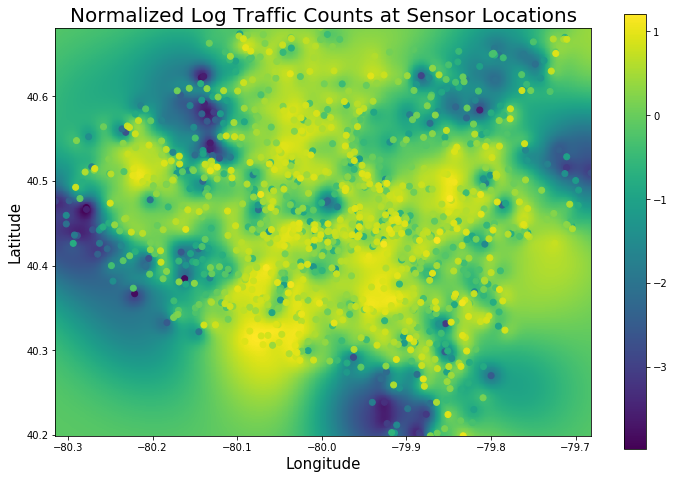

In [13]:
# Plot
plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
plt.imshow(Z_reshape, extent=(x_min, x_max, y_min, y_max), origin="lower")
obs_colors = Data1.AvgDailyTrafficCount
plt.scatter(Data1.Longitude, Data1.Latitude, alpha=1, label='Observed data', c=obs_colors)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.title('Normalized Log Traffic Counts at Sensor Locations', fontsize=20)
plt.colorbar()
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

### 4) Outlier sensors based on standard deviation

In [14]:
# Get the predicted count and sigma for each observation
predicted_count, predicted_sigma = bestgp.predict(X, return_std=True)

In [15]:
# Add to the dataframe for comparison
Data1['predicted_count'] = predicted_count
Data1['predicted_sigma'] = predicted_sigma
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,predicted_count,predicted_sigma
0,-80.278366,40.468606,-3.977526,-2.351216,0.747923
1,-80.162117,40.384598,-3.854466,-1.271783,0.743770
2,-80.221205,40.366778,-3.833632,-1.711390,0.772194
3,-80.142455,40.622084,-3.698812,-2.046463,0.742793
4,-80.131975,40.544915,-3.580029,-2.059162,0.753367


In [16]:
# Compare
Data1['over'] = Data1['AvgDailyTrafficCount'] > (Data1['predicted_count'] + (2*Data1['predicted_sigma']))
Data1['under'] = Data1['AvgDailyTrafficCount'] < (Data1['predicted_count'] - (2*Data1['predicted_sigma']))
Data1['mid'] = (Data1['over'] != 1) & (Data1['under'] != 1)
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,predicted_count,predicted_sigma,over,under,mid
0,-80.278366,40.468606,-3.977526,-2.351216,0.747923,False,True,False
1,-80.162117,40.384598,-3.854466,-1.271783,0.743770,False,True,False
2,-80.221205,40.366778,-3.833632,-1.711390,0.772194,False,True,False
3,-80.142455,40.622084,-3.698812,-2.046463,0.742793,False,True,False
4,-80.131975,40.544915,-3.580029,-2.059162,0.753367,False,True,False


In [17]:
over_under_tot = Data1.over.sum() + Data1.under.sum()
over_under_tot

23

In [18]:
print("Percentage of sensors with traffic counts either 2 SD above or below predicted count: {}%".format\
      (round(100*float(over_under_tot)/float(Data1.shape[0]), 3)))

Percentage of sensors with traffic counts either 2 SD above or below predicted count: 2.063%


### 5) Plot of outlier sensors

In [19]:
conditions = [Data1.under == 1, Data1.mid == 1]
choices = [1, 2]
Data1['cats'] = np.select(conditions, choices, default=0)

In [20]:
"""
'over' column: whether or not the observed count was more than 2SDs above the predicted value
'under' column: whether or not the observed count was more than 2SDs below the predicted value
'mid' column: whether or not the observed count fell within 2 SDs on either side of the predicted value
'cats' column: a category column for plotting (0 for 'over', 1 for 'under', and 2 for 'mid')
"""
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,predicted_count,predicted_sigma,over,under,mid,cats
0,-80.278366,40.468606,-3.977526,-2.351216,0.747923,False,True,False,1
1,-80.162117,40.384598,-3.854466,-1.271783,0.743770,False,True,False,1
2,-80.221205,40.366778,-3.833632,-1.711390,0.772194,False,True,False,1
3,-80.142455,40.622084,-3.698812,-2.046463,0.742793,False,True,False,1
4,-80.131975,40.544915,-3.580029,-2.059162,0.753367,False,True,False,1


In [21]:
Data1['lonlat'] = list(zip(Data1.Longitude, Data1.Latitude))
Data1['geometry'] = Data1[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
Data1_gdf = gpd.GeoDataFrame(Data1)
Data1_gdf.head()

,Longitude,Latitude,AvgDailyTrafficCount,predicted_count,predicted_sigma,over,under,mid,cats,lonlat,geometry
0,-80.278366,40.468606,-3.977526,-2.351216,0.747923,False,True,False,1,"(-80.27836587, 40.46860562)",POINT (-80.27836587 40.46860562)
1,-80.162117,40.384598,-3.854466,-1.271783,0.743770,False,True,False,1,"(-80.16211738, 40.38459789)",POINT (-80.16211738 40.38459789)
2,-80.221205,40.366778,-3.833632,-1.711390,0.772194,False,True,False,1,"(-80.22120473, 40.36677795)",POINT (-80.22120473 40.36677795)
3,-80.142455,40.622084,-3.698812,-2.046463,0.742793,False,True,False,1,"(-80.14245484, 40.6220841)",POINT (-80.14245484 40.6220841)
4,-80.131975,40.544915,-3.580029,-2.059162,0.753367,False,True,False,1,"(-80.13197496, 40.54491527)",POINT (-80.13197495999999 40.54491527)


/nfshome/shb395/.conda/envs/myEnvp3/lib/python2.7/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


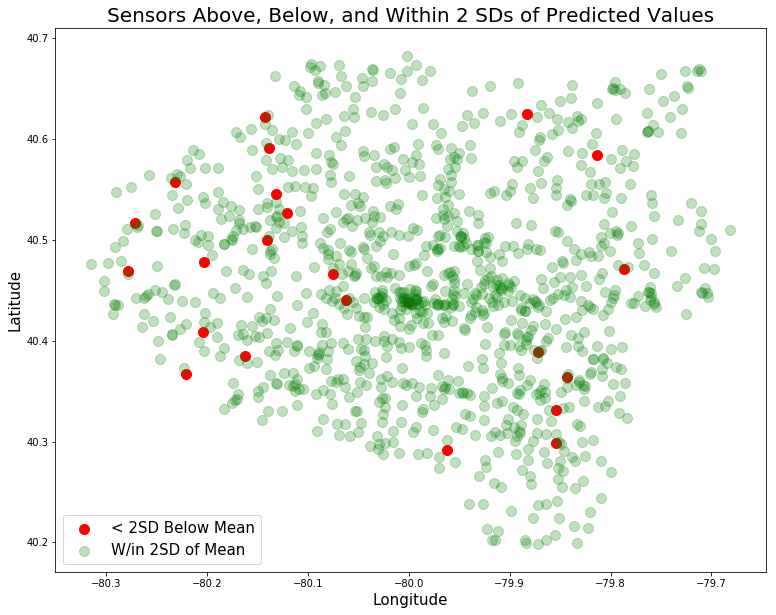

In [22]:
# Plot
f, ax = plt.subplots(figsize=(15,10))
labels = ['2SD Over','2SD Under','W/in 2SD']
Data1_gdf[Data1_gdf['cats']==0].plot(alpha=1,ax=ax,label='> 2SD Over Mean',c='b',markersize=100)
Data1_gdf[Data1_gdf['cats']==1].plot(alpha=1,ax=ax,label='< 2SD Below Mean',c='r',markersize=100)
Data1_gdf[Data1_gdf['cats']==2].plot(alpha=.25,ax=ax,label='W/in 2SD of Mean',c='g',markersize=100)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.title('Sensors Above, Below, and Within 2 SDs of Predicted Values', fontsize=20)
plt.legend(fontsize=15, loc=3)
plt.show()

## Cluster-based anomaly detection

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


In [23]:
# Function to create coordinates for visualization
def make_coords(num, sigma, x, y):
    xs = np.random.normal(x, sigma, num)
    ys = np.random.normal(y, sigma, num)
    return xs, ys

In [24]:
# Map the 4 points
coords_A = make_coords(100, .1, 0, 0)
coords_B = make_coords(150, 5, 35, 5)
coords_C = make_coords(2, 1, 15, 20)
coords_D = make_coords(200, 1, 10, 10)
all_coords = [coords_A, coords_B, coords_C, coords_D]

In [25]:
# Add in the test coordinates
new_coords = [[1, 35, 15, 10],[0, 2, 19, 11]]

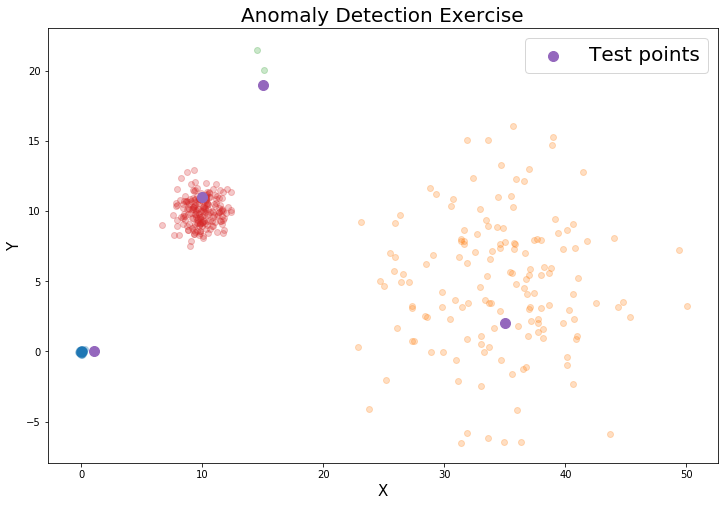

In [26]:
# Plot
plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
for coord in all_coords:
    plt.scatter(coord[0], coord[1], alpha=.25)
plt.scatter(new_coords[0], new_coords[1], alpha=1, s=100, label='Test points')
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.title('Anomaly Detection Exercise', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [27]:
# Get the centers for checking distances
centers = {'A':((0,0),.1),'B':((35, 5),5),'C':((15, 20),1),'D':((10,10),1)}

In [28]:
# Function for getting various characteristics for each of the test points
def dist_checks(x, y):
    point = (x, y)
    print("Point: {}".format(point))
    print("")
    for k,v in centers.items():
        center = v[0]
        std = v[1]
        dist = np.sqrt(((x-center[0])**2) + ((y-center[1])**2))
        std_from_mean = dist/std
        print("Cluster {}".format(k))
        print("Distance from mean: {}".format(round(dist, 3)))
        print("STDs from mean: {}".format(round(std_from_mean, 3)))
        print("")

In [29]:
# Test point 1
dist_checks(1,0)

Point: (1, 0)

Cluster A
Distance from mean: 1.0
STDs from mean: 10.0

Cluster C
Distance from mean: 24.413
STDs from mean: 24.413

Cluster B
Distance from mean: 34.366
STDs from mean: 6.873

Cluster D
Distance from mean: 13.454
STDs from mean: 13.454



In [30]:
# Test point 2
dist_checks(35, 2)

Point: (35, 2)

Cluster A
Distance from mean: 35.057
STDs from mean: 350.571

Cluster C
Distance from mean: 26.907
STDs from mean: 26.907

Cluster B
Distance from mean: 3.0
STDs from mean: 0.6

Cluster D
Distance from mean: 26.249
STDs from mean: 26.249



In [31]:
# Test point 3
dist_checks(15, 19)

Point: (15, 19)

Cluster A
Distance from mean: 24.207
STDs from mean: 242.074

Cluster C
Distance from mean: 1.0
STDs from mean: 1.0

Cluster B
Distance from mean: 24.413
STDs from mean: 4.883

Cluster D
Distance from mean: 10.296
STDs from mean: 10.296



In [32]:
# Test point 4
dist_checks(10,11)

Point: (10, 11)

Cluster A
Distance from mean: 14.866
STDs from mean: 148.661

Cluster C
Distance from mean: 10.296
STDs from mean: 10.296

Cluster B
Distance from mean: 25.71
STDs from mean: 5.142

Cluster D
Distance from mean: 1.0
STDs from mean: 1.0



### Conclusion: 

(1, 0) - Anomaly

This test point is an anomaly given that it is separated from the rest of the dense cluster of points located around center 0, 0 and it is more than 2 standard deviations away from all cluster centers.

(35, 2) - Not Anomaly

This test point is non-anomalous since it is within one standard deviation away from the center of cluster B.

(15, 19) - Anomaly

This test point is anomalous even though it is within one standard deviation of the center of cluster C. Cluster C is very sparsely populated and therefore points within this cluster are relatively anomalous.

(10, 11) - Not Anomaly

This test point is non-anomalous because it is within one standard deviation of the center of a tightly clustered set of points (cluster D).

## Anomaly Detection

In this exercise I used the "data/2016CountyHealthIndicators.csv" dataset provided to identify the most anomalous counties using different models.

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

### Part 1

Data cleaning and prep.

In [34]:
Data2=pd.read_csv("data/2016CountyHealthIndicators.csv", dtype=str)
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [35]:
Data2.dropna(inplace=True)

In [36]:
# Remove single quotes from column headers for ease
Data2 = Data2.rename(columns={col: col.replace("'","") for col in Data2.columns})
Data2 = Data2.rename(columns={col: col.replace("\% ","") for col in Data2.columns})

In [37]:
Data2.rename(columns={'80/20 Income Ratio':'Income_Ratio'}, inplace=True)

In [38]:
Data2columns = Data2.columns

In [39]:
# Remove rows with '?'
for col in Data2columns:
    Data2 = Data2[~Data2[col].str.contains("\?")]

In [40]:
Data2.head()

,County,Reporting Fair/Poor Health,Physically Unhealthy Days Per Month,Mentally Unhealthy Days Per Month,Low birth weight births,Smokers,Obese,Food Environment Index,Physically Inactive,With Access To Exercise,...,Children in Poverty,Income_Ratio,Single-Parent Households,Association Rate,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,Severe Housing Problems,Drive Alone,Long Commute - Drives Alone
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [41]:
# Now recast appropriate columns as floats
Data2[Data2columns[1:]] = Data2[Data2columns[1:]].apply(pd.to_numeric)

### Part 2

#### Part a) K-means

In [42]:
# Assign random cluster values to each crime type
random_clusters = np.random.randint(3,size=len(Data2.index))
res=pd.concat([pd.Series(Data2.County),pd.Series(random_clusters,name='cluster')],axis=1)
res.head()

,County,cluster
0,"Autauga, Alabama",0.0
1,"Baldwin, Alabama",2.0
2,"Barbour, Alabama",2.0
3,"Bibb, Alabama",1.0
4,"Blount, Alabama",1.0


In [43]:
# Create test data for clustering
test2=Data2.iloc[:,1:].values

In [44]:
# Use k-means in sklearn to cluster data into 3 k's
km = KMeans(random_state=234,n_clusters=3)
km.fit(test2)
pred=km.predict(test2)
ft=km.fit_transform(test2)

In [45]:
# Get the minimum distances from each data point to its closest cluster center
dist_mins = []
for i in range(len(ft)):
    dist_mins.append(ft[i].min())

In [46]:
# Create a df
dist_mins_df = pd.DataFrame(dist_mins)

In [47]:
# Create a df of the predicted cluster assignments
pred_df=pd.concat((pd.Series(Data2.County),pd.Series(pred, name='assigned_cluster')),axis=1)

In [48]:
# Reset index to prevent concat issues
Data2.reset_index(inplace=True, drop=True)
dist_mins_df.reset_index(inplace=True, drop=True)
pred_df.reset_index(inplace=True, drop=True)

In [49]:
# Merge the fit transform result with the data
first_merge = Data2.merge(dist_mins_df, left_index=True, right_index=True)
first_merge.rename(columns={0:'min_distance'}, inplace=True)

In [50]:
# Join the cluster centers with the data
merged = first_merge.merge(pred_df, on='County')

In [51]:
merged.rename(columns={0:'clust_0_dist',1:'clust_1_dist',2:'clust_2_dist'}, inplace=True)

In [52]:
# Check to see if values are way above or way below the mean of the entire dataset
for idx,r in merged.sort_values('min_distance', ascending=False).head().iterrows():
    print(r['County'] + ":")
    print("")
    print("More than 2 SD above the mean:")
    # Use the original columns with numerical data
    for i in range(1, 31):
        if r[i] > (merged.iloc[:,i].mean() + 2*merged.iloc[:,i].std()):
            print(merged.columns[i])
    print("")
    print("More than 2 SD below the mean:")
    for i in range(1, 31):
        if r[i] < (merged.iloc[:,i].mean() - 2*merged.iloc[:,i].std()):
            print(merged.columns[i])
    print("")

Shannon, South Dakota:

More than 2 SD above the mean:
Reporting Fair/Poor Health
Physically Unhealthy Days Per Month
Smokers
Obese
Alcohol-Impaired Driving Deaths
Chlamydia Rate
Teen Birth Rate
Preventable Hosp. Rate
Unemployed
Children in Poverty
Income_Ratio
Single-Parent Households
Injury Death Rate
Severe Housing Problems

More than 2 SD below the mean:
Food Environment Index
With Access To Exercise
Dibetics receiving HbA1c
Mammography
Graduation Rate
Drive Alone

St. Louis City, Missouri:

More than 2 SD above the mean:
Smokers
Chlamydia Rate
Children in Poverty
Income_Ratio
Single-Parent Households
Violent Crime Rate

More than 2 SD below the mean:
Graduation Rate

Crittenden, Arkansas:

More than 2 SD above the mean:
Low birth weight births
Smokers
Chlamydia Rate
Teen Birth Rate
Single-Parent Households
Violent Crime Rate

More than 2 SD below the mean:
Food Environment Index

Petersburg City, Virginia:

More than 2 SD above the mean:
Low birth weight births
Chlamydia Rate
Teen

In [53]:
print("The 5 counties with the longest cluster distances are:")
print("")
print(list(enumerate(merged.sort_values('min_distance', ascending=False).head().County.values)))

The 5 counties with the longest cluster distances are:

[(0, 'Shannon, South Dakota'), (1, 'St. Louis City, Missouri'), (2, 'Crittenden, Arkansas'), (3, 'Petersburg City, Virginia'), (4, 'Baltimore City, Maryland')]


#### Part b) Gaussian Mixture Model

In [54]:
gmm = GaussianMixture(n_components=3,random_state=100)
gmm.fit(test2)
gmm_score=gmm.score_samples(test2)
score_df=pd.DataFrame(gmm_score)

In [55]:
score_df.reset_index(inplace=True, drop=True)

In [56]:
merged = merged.merge(score_df, left_index=True, right_index=True)
merged.rename(columns={0:'gmm_ll'}, inplace=True)

In [57]:
merged.sort_values('gmm_ll').head()

,County,Reporting Fair/Poor Health,Physically Unhealthy Days Per Month,Mentally Unhealthy Days Per Month,Low birth weight births,Smokers,Obese,Food Environment Index,Physically Inactive,With Access To Exercise,...,Association Rate,Violent Crime Rate,Injury Death Rate,Average Daily PM2.5,Severe Housing Problems,Drive Alone,Long Commute - Drives Alone,min_distance,assigned_cluster,gmm_ll
1890,"Shannon, South Dakota",33,5.9,4.7,7,41,45,1.6,24,2,...,2.8,0,200,11.8,44,64,22,1970.505640,2.0,-197.420106
66,"Apache, Arizona",30,5.7,5.3,7,26,33,0.5,22,22,...,3.5,94,173,9.8,36,75,42,477.793750,2.0,-133.042814
1444,"New York, New York",14,3.5,3.5,9,13,15,7.8,18,98,...,13.0,620,32,10.8,25,6,63,155.998547,1.0,-131.452092
2158,"Willacy, Texas",37,5.2,3.6,9,20,29,7.3,27,0,...,5.9,902,47,8.7,18,90,27,462.820240,NaN,-129.450559
1577,"Roulette, North Dakota",29,5.1,4.5,10,38,41,6.9,34,21,...,6.2,29,104,9.6,21,84,14,744.072269,2.0,-126.696033


In [58]:
# Check to see if values are way above or way below the mean of the entire dataset
for idx,r in merged.sort_values('gmm_ll').head().iterrows():
    print(r['County'] + ":")
    print("")
    print("More than 2 SD above the mean:")
    # Use the original columns with numerical data
    for i in range(1, 31):
        if r[i] > (merged.iloc[:,i].mean() + 2*merged.iloc[:,i].std()):
            print(merged.columns[i])
    print("")
    print("More than 2 SD below the mean:")
    for i in range(1, 31):
        if r[i] < (merged.iloc[:,i].mean() - 2*merged.iloc[:,i].std()):
            print(merged.columns[i])
    print("")

Shannon, South Dakota:

More than 2 SD above the mean:
Reporting Fair/Poor Health
Physically Unhealthy Days Per Month
Smokers
Obese
Alcohol-Impaired Driving Deaths
Chlamydia Rate
Teen Birth Rate
Preventable Hosp. Rate
Unemployed
Children in Poverty
Income_Ratio
Single-Parent Households
Injury Death Rate
Severe Housing Problems

More than 2 SD below the mean:
Food Environment Index
With Access To Exercise
Dibetics receiving HbA1c
Mammography
Graduation Rate
Drive Alone

Apache, Arizona:

More than 2 SD above the mean:
Reporting Fair/Poor Health
Physically Unhealthy Days Per Month
Mentally Unhealthy Days Per Month
Smokers
Chlamydia Rate
Unemployed
Income_Ratio
Injury Death Rate
Severe Housing Problems

More than 2 SD below the mean:
Food Environment Index
Dibetics receiving HbA1c
Mammography
Graduation Rate

New York, New York:

More than 2 SD above the mean:
Some College
Income_Ratio
Severe Housing Problems
Long Commute - Drives Alone

More than 2 SD below the mean:
Obese
Graduation Rat

In [59]:
print("The 5 counties with the lowest log likelihoods are:")
print("")
print(list(enumerate(merged.sort_values('gmm_ll').head().County.values)))

The 5 counties with the lowest log likelihoods are:

[(0, 'Shannon, South Dakota'), (1, 'Apache, Arizona'), (2, 'New York, New York'), (3, 'Willacy, Texas'), (4, 'Roulette, North Dakota')]


### Part 3

In [60]:
# Using a Local Outlier Factor model
clf = LocalOutlierFactor(n_neighbors=20, novelty=True)
clf.fit(test2)
clf_score = clf.score_samples(test2)
clf_df=pd.DataFrame(clf_score)

/nfshome/shb395/.conda/envs/myEnvp3/lib/python2.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [61]:
clf_df.reset_index(inplace=True, drop=True)

In [62]:
merged = merged.merge(clf_df, left_index=True, right_index=True)
merged.rename(columns={0:'clf_scores'}, inplace=True)

In [63]:
# Check to see if values are way above or way below the mean of the entire dataset
for idx,r in merged.sort_values('clf_scores', ascending=True).head().iterrows():
    print(r['County'] + ":")
    print("")
    print("More than 2 SD above the mean:")
    # Use the original columns with numerical data
    for i in range(1, 31):
        if r[i] > (merged.iloc[:,i].mean() + 2*merged.iloc[:,i].std()):
            print(merged.columns[i])
    print("")
    print("More than 2 SD below the mean:")
    for i in range(1, 31):
        if r[i] < (merged.iloc[:,i].mean() - 2*merged.iloc[:,i].std()):
            print(merged.columns[i])
    print("")

Shannon, South Dakota:

More than 2 SD above the mean:
Reporting Fair/Poor Health
Physically Unhealthy Days Per Month
Smokers
Obese
Alcohol-Impaired Driving Deaths
Chlamydia Rate
Teen Birth Rate
Preventable Hosp. Rate
Unemployed
Children in Poverty
Income_Ratio
Single-Parent Households
Injury Death Rate
Severe Housing Problems

More than 2 SD below the mean:
Food Environment Index
With Access To Exercise
Dibetics receiving HbA1c
Mammography
Graduation Rate
Drive Alone

St. Louis City, Missouri:

More than 2 SD above the mean:
Smokers
Chlamydia Rate
Children in Poverty
Income_Ratio
Single-Parent Households
Violent Crime Rate

More than 2 SD below the mean:
Graduation Rate

Crittenden, Arkansas:

More than 2 SD above the mean:
Low birth weight births
Smokers
Chlamydia Rate
Teen Birth Rate
Single-Parent Households
Violent Crime Rate

More than 2 SD below the mean:
Food Environment Index

Nicholas, West Virginia:

More than 2 SD above the mean:
Physically Inactive
Violent Crime Rate
Injury

In [64]:
print("The 5 counties with the largest local outlier factors are:")
print("")
print(list(enumerate(merged.sort_values('clf_scores', ascending=True).head().County.values)))

The 5 counties with the largest local outlier factors are:

[(0, 'Shannon, South Dakota'), (1, 'St. Louis City, Missouri'), (2, 'Crittenden, Arkansas'), (3, 'Nicholas, West Virginia'), (4, 'Petersburg City, Virginia')]


### Part 4

While the K-means and Local Outlifer Factor anomaly detection methods produced similar results, the Gaussian Mixture Model produced unique results except for Shannon, South Dakota, which was found to be the most anomalous county across all three methods. What is consistent, however, across all three models, is that the resulting counties score either relatively high or relatively low across multiple health metrics. Many are either more than 2 standard deviations above or less than 2 standarand deviations below the mean for measures such as smoking rates, the food environment index, teen birth rates, and other measures. Since these counties tend to score very high or very low on these measures, it makes sense that our detection models have selected them as anomalies.